In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import balanced_accuracy_score as BACC
import seaborn as sns
from sklearn.svm import SVC, LinearSVC
#from google.colab import drive
#drive.mount('/content/drive')

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-10-27 02:14:34.336881: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-27 02:14:34.360320: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-27 02:14:34.360343: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-27 02:14:34.360359: E tensorflow/c

## Data Processing

In [2]:
def load_data():
    """ Load the training and test data. """
    #2352 elements each image: 2352 = pixels x pixels x 3 (RGB)
    X = np.load('/content/drive/MyDrive/ML/Lab3/Xtrain_Classification1.npy') #6254 x 2352. 2352 = pixels x pixels x 3 (RGB)
    y = np.load('/content/drive/MyDrive/ML/Lab3/ytrain_Classification1.npy') #6254. 1D vector
    X_t = np.load('/content/drive/MyDrive/ML/Lab3/Xtest_Classification1.npy') #1764 x 2352. Has data from two distinct sourcesm two distinct sources
    return X, y, X_t

def load_data_2():
    """ Load the training and test data. """
    #2352 elements each image: 2352 = pixels x pixels x 3 (RGB)
    X = np.load('Xtrain_Classification1.npy') #6254 x 2352. 2352 = pixels x pixels x 3 (RGB)
    y = np.load('ytrain_Classification1.npy') #6254. 1D vector
    X_t = np.load('Xtest_Classification1.npy') #1764 x 2352. Has data from two distinct sourcesm two distinct sources
    return X, y, X_t


def preprocess_data(X, X_t):
    """ This function scale the training data to be in the range [0, 1]
    and the data type to float32 for numerical stability """
    Xs = (X).astype('float32') / np.max(X) #Scale down data [0,1]
    Xs_test = (X_t).astype('float32') / np.max(X)
    return Xs, Xs_test

def encode_data(y, Xs, y_test, Xs_test):
    """ Enconde data function """
    train_labels = keras.utils.to_categorical(y,num_classes=2) #One-hot enconding: 6254 x 2 matrix that is 0 or 1 depending on class
    val_labels = keras.utils.to_categorical(y_test,num_classes=2)
    train_images = np.reshape(Xs, (len(Xs[:,0]),28,28,3)) #4D array. number of images x width x height x color
    val_images = np.reshape(Xs_test, (len(Xs_test[:,0]), 28, 28, 3))
    return train_labels, train_images, val_images, val_labels

def shuffle_data(train_images, train_labels):
    permutation = np.random.permutation(len(train_images))
    train_images_s = train_images[permutation]
    train_labels_s = train_labels[permutation]
    return train_images_s, train_labels_s

def split_data(train_images_s, train_labels_s):
    X_train, X_validation, y_train, y_validation = train_test_split(train_images_s, train_labels_s, test_size=0.15)
    print("Split X_train: ", X_train.shape)
    print("Split y_train: ", y_train.shape)
    return X_train, X_validation, y_train, y_validation

def plot_images(number_images,X_train):
  '''Plot a user defined number of images from X_train. Only really works for 10 images'''
  number_images = 10
  plt.figure(figsize=(12, 6))
  for i in range(number_images):
      plt.subplot(2, 5, i + 1)
      plt.imshow(X_train[i])
      plt.title(f"Image {i+1}")
      plt.axis('off')
  plt.tight_layout()
  plt.show()

######################## RESULTS ############################

def make_predictions(MLP, val_images):
    predictions = MLP.predict(x = val_images, batch_size = 200, verbose=0) #Returns probability of each class
    rounded_predictions= np.argmax(predictions, axis=-1) #Rounds it to 0 or 1
    return rounded_predictions

def plot(history):
    plt.figure(figsize=(15, 5))  # Increase the figure size

    # Create the first subplot (Loss)
    plt.subplot(2, 2, 1)  # Create a subplot with 1 row and 3 columns, and select the first subplot
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Create the second subplot (F1 Score)
    plt.subplot(2, 2, 2)  # Select the second subplot
    plt.plot(history.history['f1_score'], 'g', label='Training F1 Score')
    plt.plot(history.history['val_f1_score'], 'r', label='Validation F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title('Training and Validation F1 Score')
    plt.legend()

    # Create the third subplot (Balanced Accuracy)
    plt.subplot(2, 2, 3)  # Select the third subplot
    plt.plot(history.history['balanced_accuracy_custom'], 'b', label='Training Balanced Accuracy')
    plt.plot(history.history['val_balanced_accuracy_custom'], 'y', label='Validation Balanced Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Balanced Accuracy')
    plt.title('Training and Validation Balanced Accuracy')
    plt.legend()

    # Create the third subplot (Balanced Accuracy)
    plt.subplot(2, 2, 4)  # Select the third subplot
    plt.plot(history.history['sensitivity_custom'], 'b', label='Training Sensitivity Accuracy')
    plt.plot(history.history['val_sensitivity_custom'], 'y', label='Validation Sensitivity Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Sensitivity Accuracy')
    plt.title('Training and Validation Sensitivity Accuracy')
    plt.legend()

    plt.tight_layout()  # Ensure that the subplots don't overlap
    plt.show()


def check_imbalance(MLP, val_images):
    rounded_predictions = make_predictions(MLP, val_images) #Make predictions
    cont_0 = 0
    for i in rounded_predictions: #Visualize imbalance in training data
        if i == 0:
            cont_0 += 1
    print(cont_0, len(val_images[:,0])-cont_0) #Big difference between classes due to imbalanced training set

def check_results(history):
    plot(history)
    print("Train - Loss: {:.4f}".format(history.history['loss'][-1]))
    print("Test  - Val Loss: {:.4f}".format(np.mean(history.history['val_loss'][-1])))
    train_f1_score = np.mean(history.history['f1_score'])
    val_f1_score = np.mean(history.history['val_f1_score'])
    print("Train - Mean F1 Score: {:.4f}".format(train_f1_score))
    print("Test - Mean Val F1 Score: {:.4f}".format(val_f1_score))
    train_sensitivity = history.history['sensitivity_custom'][-1]
    val_sensitivity = history.history['val_sensitivity_custom'][-1]
    print("Train - Final Sensitivity: {:.4f}".format(train_sensitivity))
    print("Test - Final Val Sensitivity: {:.4f}".format(val_sensitivity))
    train_balanced_accuracy = history.history['balanced_accuracy_custom'][-1]
    val_balanced_accuracy = history.history['val_balanced_accuracy_custom'][-1]
    print("Train - Final Balanced Accuracy: {:.4f}".format(train_balanced_accuracy))
    print("Test - Final Val Balanced Accuracy: {:.4f}".format(val_balanced_accuracy))


def save_model (model_fitted, model_history, optimizer_string, loss_string ,epoch_nr,batch,best_balancedAccuracy ):
    file_name_model=f"bestbacc_{best_balancedAccuracy}  {optimizer_string}  {loss_string}  Epoch_{epoch_nr}  Batch_{batch}  Model.keras"
    file_name_history=f"bestbacc_{best_balancedAccuracy}  {optimizer_string}  {loss_string}  Epoch_{epoch_nr}  Batch_{batch}  History.npy"
    model_fitted.save(file_name_model)
    np.save(file_name_history,model_history.history)

X, y, X_t = load_data_2()
Xs, Xs_test = preprocess_data(X, X_t)
X_train, X_validation, y_train, y_validation = split_data(Xs, y)
X_train_shuffle, y_train_shuffle = shuffle_data(X_train, y_train)
train_labels, train_images, val_images, val_labels = encode_data(y_train_shuffle, X_train_shuffle, y_validation, X_validation)
#plot_images(10, train_images)

Split X_train:  (5315, 2352)
Split y_train:  (5315,)


## Validation Metrics

In [3]:
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        pt = y_pred * y_true + (1 - y_pred) * (1 - y_true) # Get the "modulated" probabilities
        return -K.sum(alpha * K.pow(1.0 - pt, gamma) * K.log(pt + K.epsilon()))
    return focal_loss_fixed

def f1_score(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')  # Cast y_true to float32
    y_pred = K.cast(K.round(y_pred), 'float32')  # Cast y_pred to float32

    # Compute precision, recall
    precision = K.sum(y_true * y_pred) / (K.sum(y_pred) + K.epsilon())
    recall = K.sum(y_true * y_pred) / (K.sum(y_true) + K.epsilon())

    # Compute F1 score
    f1_score = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_score

def specificity_custom(y_pred_onehot, y_true_onehot):
    """ How well can identify true negatives """
    y_pred = tf.argmax(y_pred_onehot, axis=1)
    y_true = tf.argmax(y_true_onehot, axis=1)
    neg_y_true = 1 - y_true
    neg_y_pred = 1 - y_pred
    fp = tf.reduce_sum(tf.cast(neg_y_true, dtype=tf.float32) * tf.cast(y_pred, dtype=tf.float32))  # false positives
    tn = tf.reduce_sum(tf.cast(neg_y_true, dtype=tf.float32) * tf.cast(neg_y_pred, dtype=tf.float32))  # true negatives
    if fp + tn == 0:
        return 0.0
    return tn / (tn + fp)

# One hot enconding -> ["apple", "banana", "cherry"].
# "apple" becomes [1, 0, 0], "banana" becomes [0, 1, 0], "cherry" becomes [0, 0, 1]
def sensitivity_custom(y_pred_onehot, y_true_onehot):
    """ How well can identify true positives """
    y_pred = tf.argmax(y_pred_onehot, axis=1) # sensitivity(recall)
    y_true = tf.argmax(y_true_onehot, axis=1)
    neg_y_pred = 1 - y_pred
    fn = tf.reduce_sum(tf.cast(neg_y_pred, dtype=tf.float32) * tf.cast(y_true, dtype=tf.float32))
    tp = tf.reduce_sum(tf.cast(y_true, dtype=tf.float32) * tf.cast(y_pred, dtype=tf.float32))
    if tp + fn == 0:
        return 0.0
    return tp / (tp + fn)

def balanced_accuracy_custom(y_pred_onehot, y_true_onehot):
    """ Average of specificity and sensitivity """
    specificity_val = specificity_custom(y_pred_onehot, y_true_onehot)
    sensitivity_val = sensitivity_custom(y_pred_onehot, y_true_onehot)
    return (specificity_val + sensitivity_val) / 2

def bacc(cnn_model, X, y_real):
    y_pred = cnn_model.predict(X_validation)
    #Convert one-hot encoded true/predictions labels to categorical labels
    y_true_labels = np.argmax(y_validation, axis=1)
    y_pred_labels = np.argmax(y_pred, axis=1)
    bacc = BACC(y_true_labels, y_pred_labels)
    return bacc

## Convolution Neural Networks

In [4]:
#Building MLP neural network, Sequential (linear stack of Layers); kernel size 3 by 3 is normal in image data
#padding keeps images in the same size; poolsize and strides -> Check notes on notion on maxpooling
def Convolution_NN_1():
    cnn = keras.Sequential([
        keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation = 'relu', padding= 'same', input_shape = (28,28,3)),
        keras.layers.MaxPool2D(pool_size =(2,2), strides=2),
        keras.layers.Dropout(0.25),
        keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation = 'relu', padding='same'),
        keras.layers.MaxPool2D(pool_size=(2,2), strides=2),
        keras.layers.Dropout(0.25),
        keras.layers.Flatten(), #Flatten is always needed before using fully connected layer (Dense) for output
        keras.layers.Dense(units=2, activation='softmax')
    ])
    #cnn.summary() #See created neural network
    return cnn

def Convolution_NN_2(): #another model
    cnn_model1 = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3),1, activation='relu', input_shape=(28, 28, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3),1, activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3),1, activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(2,activation='softmax')
    ])
    return cnn_model1

def Convolution_NN_3():
    cnn_model2 = keras.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu',padding='same',input_shape=(28, 28, 3)),
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu',padding='same'),
    keras.layers.MaxPooling2D(pool_size=(2, 2),strides=2),
    keras.layers.Dropout(0.2),
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2),strides=2),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.7),
    keras.layers.Dense(2, activation='softmax')
    ])
    return cnn_model2


def Convolution_NN_4():
    cnn = keras.Sequential([
    keras.layers.Conv2D(32, kernel_size =(3,3), padding='same', activation='relu', input_shape=(28,28,3)),
    keras.layers.Conv2D(32,(3,3),activation='relu', padding='same'),
    keras.layers.AveragePooling2D(pool_size=(2,2), strides=2),
    keras.layers.Dropout(0.25),
    keras.layers.Conv2D(64,(3,3),activation='relu', padding='same'),
    keras.layers.AveragePooling2D(pool_size=(2,2), strides=2),
    keras.layers.Dropout(0.25),
    keras.layers.Conv2D(128,(3,3),activation='relu', padding='same'),
    keras.layers.AveragePooling2D(pool_size=(2,2),strides=2),
    keras.layers.Dropout(0.25),
    keras.layers.Flatten(),
    keras.layers.Dense(256,activation='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(256,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2,activation='softmax')
    ])
    return cnn


#BACC , F1 , Confusion matrix, Classification_report
def Compile_MLP_categorical_crossentropy(MLP):
    MLP.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=[keras.metrics.F1Score(), sensitivity_custom ,\
                                                                                        balanced_accuracy_custom ]) #accuracy only used for balanced data

def Compile_MLP_focal_loss(MLP):
    MLP.compile(optimizer=Adam(learning_rate=0.0001), loss=focal_loss(), metrics=[keras.metrics.F1Score()])

def Compile_MLP_binary_crossentropy(MLP):
    MLP.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=[keras.metrics.F1Score()])

## Training CNN's

In [5]:
def class_weights(y_train):
    y_train_int = tf.argmax(y_train, axis=1)
    y_train_int_np = y_train_int.numpy()
    weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_int_np), y=y_train_int_np)
    class_weights = {i: weights[i] for i in range(len(weights))}
    return class_weights


def train_model_class_weights(MLP, X_train, y_train, X_validation, y_validation, in_verbose):
    early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True) #Patince is the number of epochs whithout improvements
    history = MLP.fit(X_train, y_train, validation_data=(X_validation, y_validation),
                   batch_size=512, epochs=200, shuffle=True, verbose=in_verbose, callbacks=[early_stop],
                   class_weight=class_weights(y_train))
    return history

def train_model(MLP, X_train, y_train, X_validation, y_validation, in_verbose):
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) #Patince is the number of epochs whithout improvements
    history = MLP.fit(X_train, y_train, validation_data=(X_validation, y_validation),
                   batch_size=512, epochs=200, shuffle=True, verbose=in_verbose, callbacks=[early_stop])
    return history

# Creating Class Weights

### Main CNN_1 with class weights

In [6]:
#Categorical crossentropy with classweights - FIRST CNN
NN_model_1_1 = Convolution_NN_1()
Compile_MLP_categorical_crossentropy(NN_model_1_1)
history = train_model_class_weights(NN_model_1_1, train_images, train_labels, val_images, val_labels, 0)

2023-10-27 01:33:32.883021: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-27 01:33:32.923668: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


30/30 [==============================] - 0s 2ms/step - loss: 0.4427 - f1_score: 0.6813 - sensitivity_custom: 0.3727 - balanced_accuracy_custom: 0.6694
Test f1: [0.85438234 0.5081585 ]


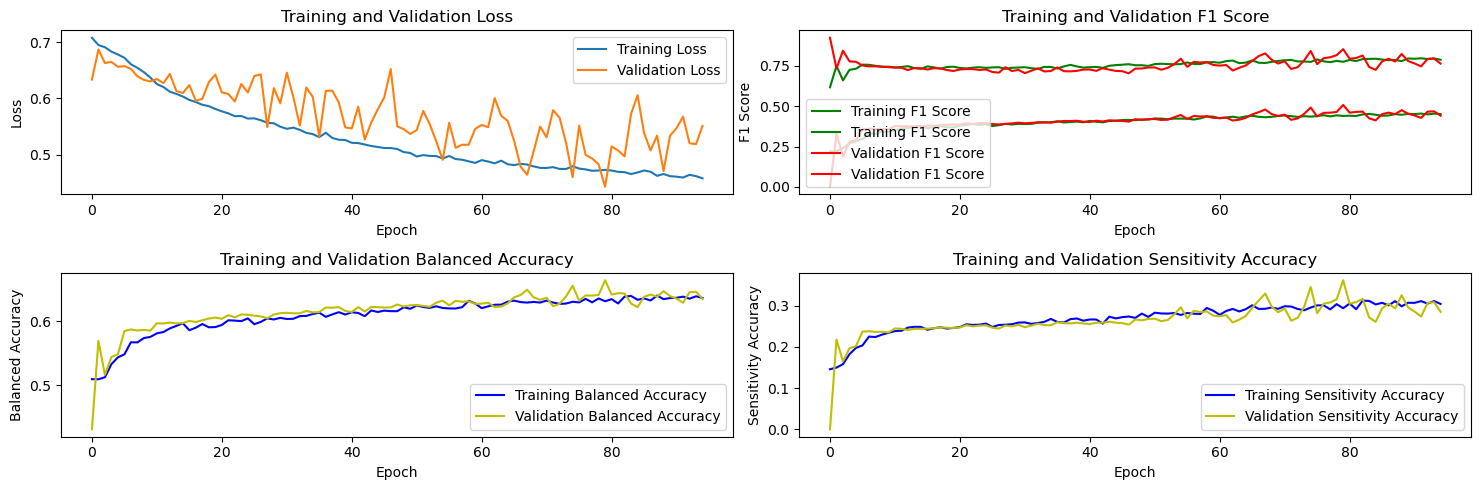

Train - Loss: 0.4577
Test  - Val Loss: 0.5509
Train - Mean F1 Score: 0.5803
Test - Mean Val F1 Score: 0.5815
Train - Final Sensitivity: 0.3044
Test - Final Val Sensitivity: 0.2852
Train - Final Balanced Accuracy: 0.6365
Test - Final Val Balanced Accuracy: 0.6349
641 298


In [7]:
test_eval = NN_model_1_1.evaluate(val_images, val_labels, verbose=1)
print('Test f1:', test_eval[1]) 
check_results(history)
check_imbalance(NN_model_1_1, val_images)

### CNN_2 (categorical crossentropy) with classweights 

In [9]:
#Categorical crossentropy with classweights - SECOND CNN

NN_model_1_2 = Convolution_NN_2()
Compile_MLP_categorical_crossentropy(NN_model_1_2)
history = train_model_class_weights(NN_model_1_2, train_images, train_labels, val_images, val_labels, 0)

30/30 [==============================] - 0s 2ms/step - loss: 0.3731 - f1_score: 0.6945 - sensitivity_custom: 0.4062 - balanced_accuracy_custom: 0.6736
Test f1: [0.8861257  0.50285715]


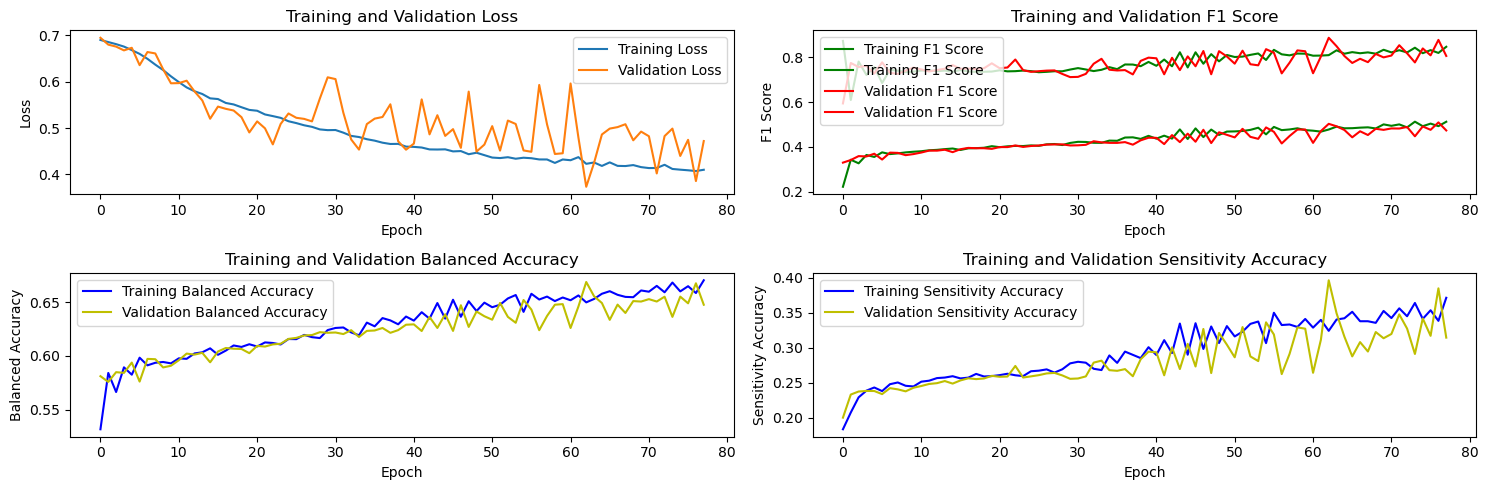

Train - Loss: 0.4098
Test  - Val Loss: 0.4718
Train - Mean F1 Score: 0.6050
Test - Mean Val F1 Score: 0.5986
Train - Final Sensitivity: 0.3716
Test - Final Val Sensitivity: 0.3147
Train - Final Balanced Accuracy: 0.6703
Test - Final Val Balanced Accuracy: 0.6476
720 219


In [10]:
test_eval_2 = NN_model_1_2.evaluate(val_images, val_labels, verbose=1)
print('Test f1:', test_eval_2[1]) 
check_results(history)
check_imbalance(NN_model_1_2, val_images)

### CNN_4 (categorical crossentropy) with classweights

In [11]:
#Categorical crossentropy with classweights - FORTH CNN
NN_model_1_4 = Convolution_NN_4()
Compile_MLP_categorical_crossentropy(NN_model_1_4)
history = train_model_class_weights(NN_model_1_4, train_images, train_labels, val_images, val_labels, 0)

30/30 [==============================] - 0s 4ms/step - loss: 0.4275 - f1_score: 0.6427 - sensitivity_custom: 0.3209 - balanced_accuracy_custom: 0.6329
Test f1: [0.8382657  0.44705883]


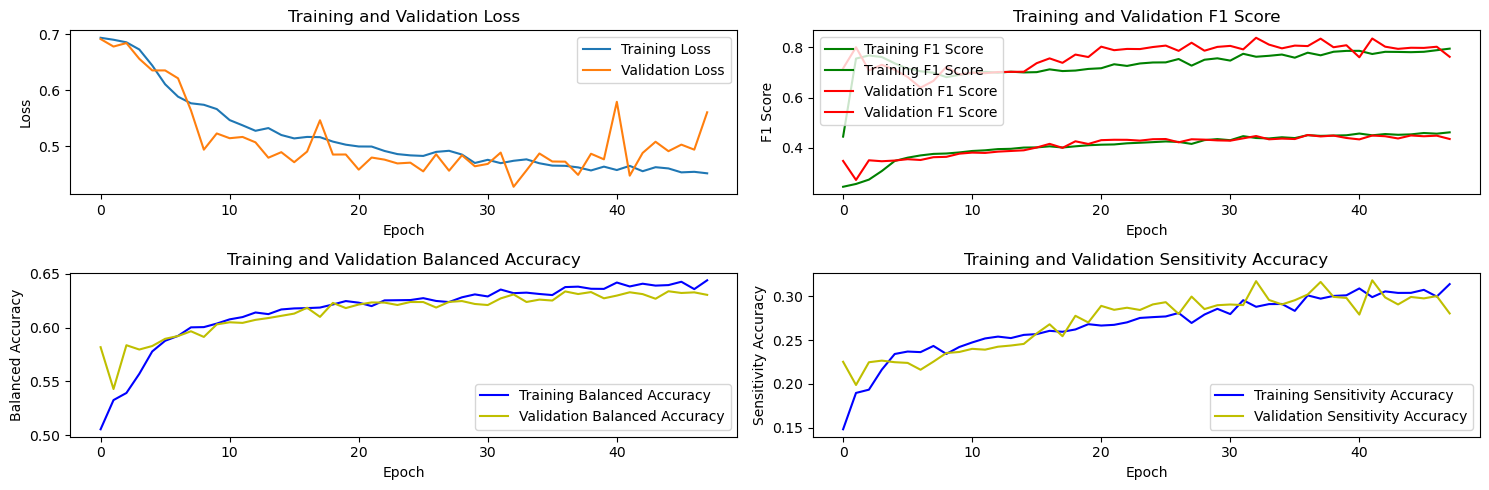

Train - Loss: 0.4515
Test  - Val Loss: 0.5605
Train - Mean F1 Score: 0.5723
Test - Mean Val F1 Score: 0.5885
Train - Final Sensitivity: 0.3141
Test - Final Val Sensitivity: 0.2806
Train - Final Balanced Accuracy: 0.6441
Test - Final Val Balanced Accuracy: 0.6305
645 294


In [12]:
test_eval_3 = NN_model_1_4.evaluate(val_images, val_labels, verbose=1)
print('Test f1:', test_eval_3[1]) 
check_results(history)
check_imbalance(NN_model_1_4, val_images)

# Data augmentation

### CNN_4 with data augmentation with class weights

In [ ]:
############### SECOND APPROACH - BALANCED DATA #############

#Create ways to do data augmentation
def data_augmentation(x, y, augmentation_factor):
    #augmentation_factor is total nr_samples after augmentation / original nr of samples (always >1)
    data_generator = keras.preprocessing.image.ImageDataGenerator(
        rotation_range=360,
        width_shift_range=10,
        height_shift_range=10,
        brightness_range=[0.7,1.3],
        zoom_range=0.2,
        fill_mode='nearest',
        horizontal_flip=True,
        vertical_flip=True,
        )
    X_train_reshape = np.reshape(x,(x.shape[0],28,28,3))
    data_generator.fit(X_train_reshape)
    #creating arrays of new data/augmented data
    x_augmented = np.empty([0,x.shape[1]])
    y_augmented = np.empty([0, 1])
    #generating data

    for batch_x, batch_y in data_generator.flow(X_train_reshape, y, batch_size=32, seed=500):
        x_augmented = np.vstack([x_augmented,np.reshape(batch_x,(batch_x.shape[0],2352))])
        y_augmented = np.vstack([y_augmented, np.reshape(batch_y,(batch_y.shape[0],1))])
        if x_augmented.shape[0] > (x.shape[0])*(augmentation_factor-1): #stops when generated enougth data to satisfy the augmentation factor
            break


    x_train_aug=np.vstack([x, x_augmented])
    y_train_aug=np.vstack([np.reshape(y, (y.shape[0],1)), y_augmented])
    return x_train_aug, y_train_aug

# Load your data
X, y, X_t = load_data_2()
new_Xtrain, new_Ytrain = data_augmentation(X, y, 1.5)
Xs, Xs_test = preprocess_data(new_Xtrain, X_t)
X_train, X_validation, y_train, y_validation = split_data(Xs, new_Ytrain)
X_train_shuffle, y_train_shuffle = shuffle_data(X_train, y_train)
train_labels, train_images, val_images, val_labels = encode_data(y_train_shuffle, X_train_shuffle, y_validation, X_validation)
NN_aug = Convolution_NN_4()
Compile_MLP_categorical_crossentropy(NN_aug)
#history = NN_aug.fit(train_images, train_labels, validation_data=(val_images, val_labels), batch_size=512, epochs=200, shuffle=True, verbose=0)
history = train_model_class_weights(NN_aug, train_images, train_labels, val_images, val_labels, 0)

45/45 [==============================] - 0s 4ms/step - loss: 0.4368 - f1_score: 0.6550 - sensitivity_custom: 0.3226 - balanced_accuracy_custom: 0.6261
Test f1: [0.8334893 0.4764706]


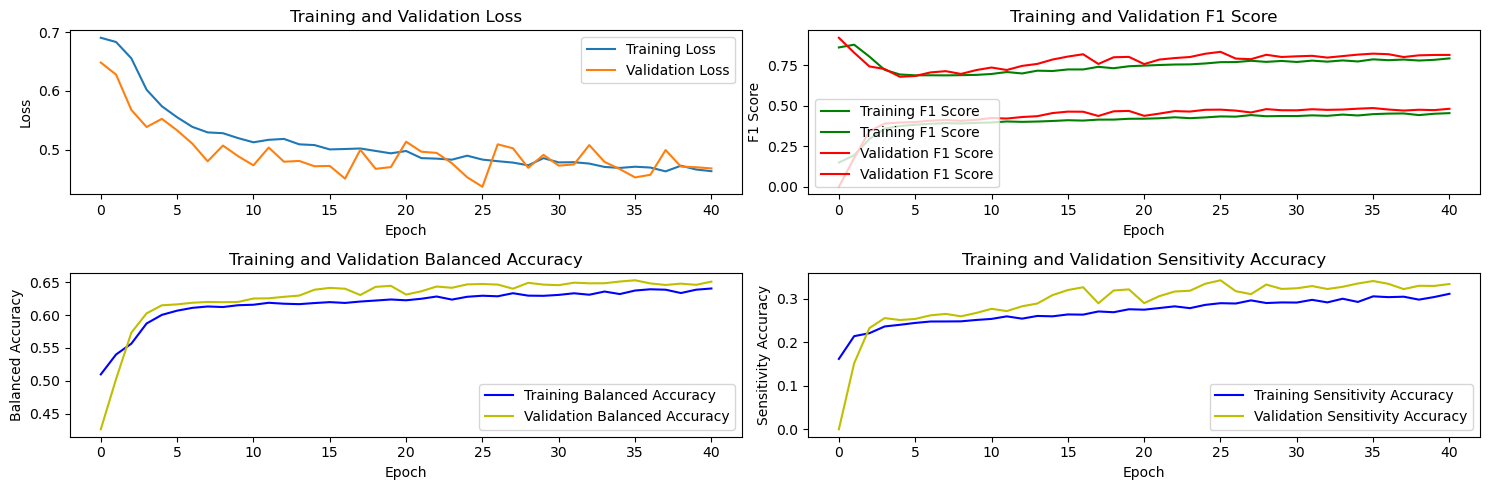

Train - Loss: 0.4634
Test  - Val Loss: 0.4680
Train - Mean F1 Score: 0.5787
Test - Mean Val F1 Score: 0.6072
Train - Final Sensitivity: 0.3116
Test - Final Val Sensitivity: 0.3342
Train - Final Balanced Accuracy: 0.6404
Test - Final Val Balanced Accuracy: 0.6508
937 472


In [15]:
test_eval_4 = NN_aug.evaluate(val_images, val_labels, verbose=1)
print('Test f1:', test_eval_4[1])
check_results(history)
check_imbalance(NN_aug, val_images)

### CNN1 with SMOTE oversampling and class weights

In [ ]:
# Synthetic Minority Over-sampling Technique
from imblearn.over_sampling import SMOTE

#It uses SMOTE to oversample the minority class, adjusting the number of samples for each class.
def oversample_data(train_images, train_labels):
    smote = SMOTE(sampling_strategy='auto')
    train_images_reshaped = train_images.reshape(-1, 28*28*3)  # Reshape images for SMOTE
    train_images_oversampled_reshaped, train_labels_oversampled = smote.fit_resample(train_images_reshaped, train_labels)
    train_images_oversampled = train_images_oversampled_reshaped.reshape(-1, 28, 28, 3)  # Reshape back to original shape
    return train_images_oversampled, train_labels_oversampled

X, y, X_t = load_data_2()
Xs, Xs_test = preprocess_data(X, X_t)
X_train, X_validation, y_train, y_validation = split_data(Xs, y)

train_balanced_x, train_balanced_y = oversample_data(X_train, y_train)
X_train_shuffle, y_train_shuffle = shuffle_data(train_balanced_x, train_balanced_y)
train_labels, train_images, val_images, val_labels = encode_data(y_train_shuffle, X_train_shuffle, y_validation, X_validation)
#plot_images(10, train_images_s_oversampled)

MLP_oversampled = Convolution_NN_1()
Compile_MLP_categorical_crossentropy(MLP_oversampled)
history_oversampled = train_model_class_weights(MLP_oversampled, train_images, train_labels, val_images, val_labels, 0)
check_results(history_oversampled)
check_imbalance(MLP_oversampled, val_images)

30/30 [==============================] - 0s 4ms/step - loss: 0.5489 - f1_score: 0.6145 - sensitivity_custom: 0.3145 - balanced_accuracy_custom: 0.6415
Test f1: [0.7791044  0.44981414]


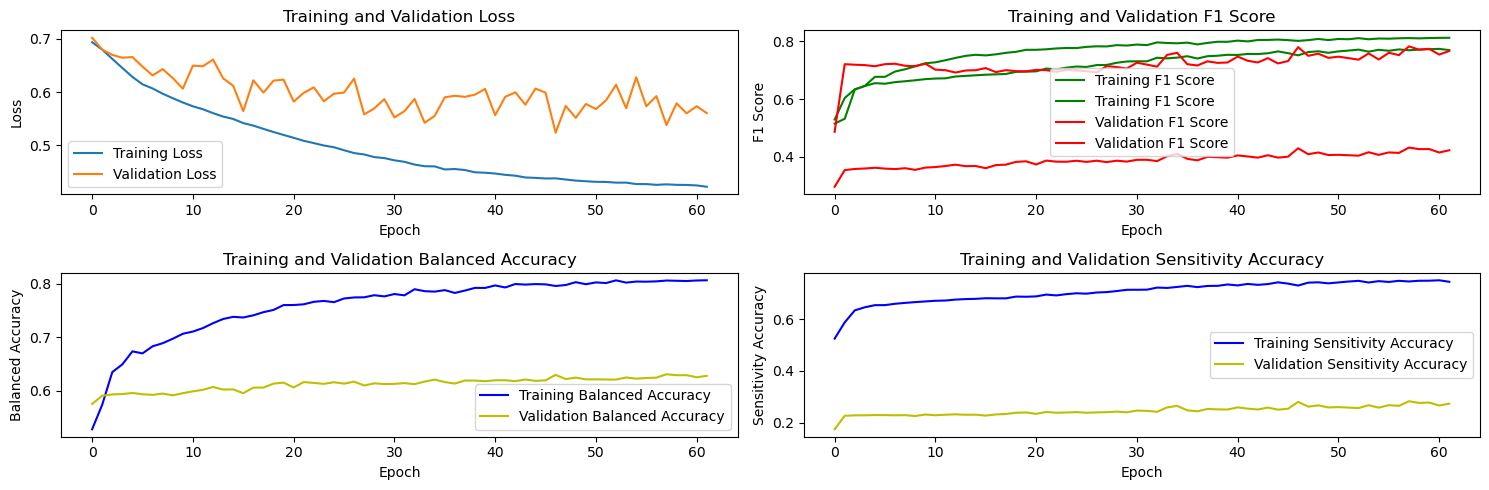

Train - Loss: 0.4226
Test  - Val Loss: 0.5608
Train - Mean F1 Score: 0.7430
Test - Mean Val F1 Score: 0.5550
Train - Final Sensitivity: 0.7436
Test - Final Val Sensitivity: 0.2740
Train - Final Balanced Accuracy: 0.8062
Test - Final Val Balanced Accuracy: 0.6277
540 399


In [22]:
test_eval_5 = MLP_oversampled.evaluate(val_images, val_labels, verbose=1)
print('Test f1:', test_eval_5[1])
check_results(history_oversampled)
check_imbalance(MLP_oversampled, val_images)

### CNN4 with SMOTE oversampling and class weights

In [23]:
# Synthetic Minority Over-sampling Technique with FORTH NN
from imblearn.over_sampling import SMOTE

#It uses SMOTE to oversample the minority class, adjusting the number of samples for each class.
def oversample_data(train_images, train_labels):
    smote = SMOTE(sampling_strategy='auto')
    train_images_reshaped = train_images.reshape(-1, 28*28*3)  # Reshape images for SMOTE
    train_images_oversampled_reshaped, train_labels_oversampled = smote.fit_resample(train_images_reshaped, train_labels)
    train_images_oversampled = train_images_oversampled_reshaped.reshape(-1, 28, 28, 3)  # Reshape back to original shape
    return train_images_oversampled, train_labels_oversampled

X, y, X_t = load_data_2()
Xs, Xs_test = preprocess_data(X, X_t)
X_train, X_validation, y_train, y_validation = split_data(Xs, y)

train_balanced_x, train_balanced_y = oversample_data(X_train, y_train)
X_train_shuffle, y_train_shuffle = shuffle_data(train_balanced_x, train_balanced_y)
train_labels, train_images, val_images, val_labels = encode_data(y_train_shuffle, X_train_shuffle, y_validation, X_validation)
#plot_images(10, train_images_s_oversampled)

MLP_oversampled = Convolution_NN_4()
Compile_MLP_categorical_crossentropy(MLP_oversampled)
history_oversampled = train_model_class_weights(MLP_oversampled, train_images, train_labels, val_images, val_labels, 0)

Split X_train:  (5315, 2352)
Split y_train:  (5315,)


30/30 [==============================] - 0s 4ms/step - loss: 0.4575 - f1_score: 0.6356 - sensitivity_custom: 0.3059 - balanced_accuracy_custom: 0.6268
Test f1: [0.8307906  0.44036698]


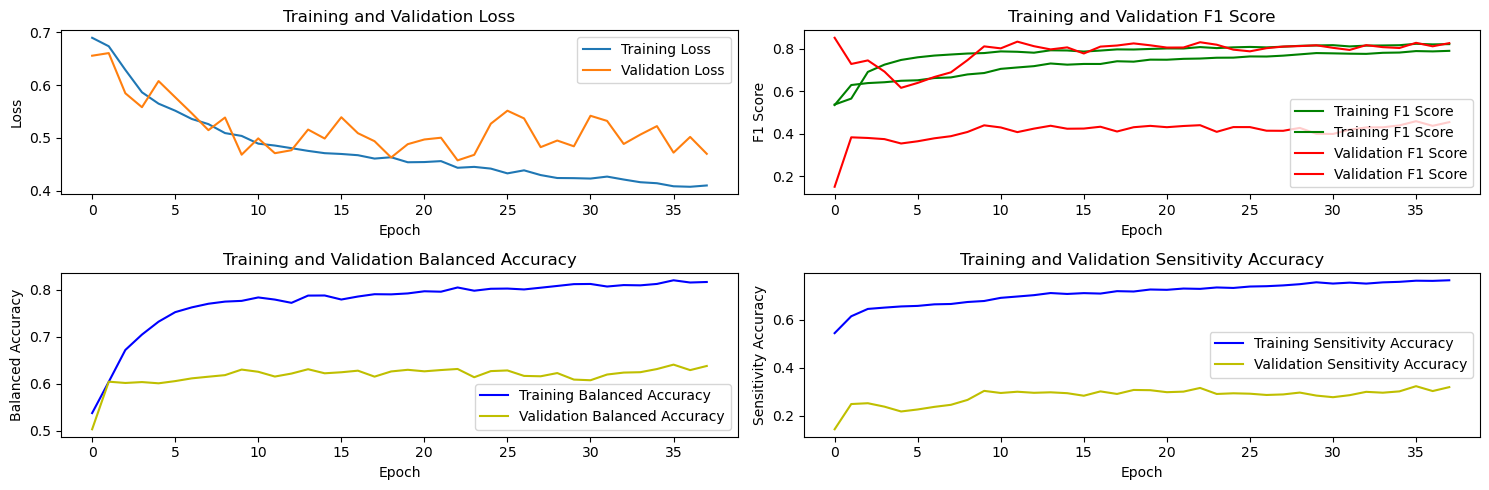

Train - Loss: 0.4099
Test  - Val Loss: 0.4699
Train - Mean F1 Score: 0.7534
Test - Mean Val F1 Score: 0.5981
Train - Final Sensitivity: 0.7647
Test - Final Val Sensitivity: 0.3195
Train - Final Balanced Accuracy: 0.8161
Test - Final Val Balanced Accuracy: 0.6376
633 306


In [24]:
test_eval_6 = MLP_oversampled.evaluate(val_images, val_labels, verbose=1)
print('Test f1:', test_eval_6[1])
check_results(history_oversampled)
check_imbalance(MLP_oversampled, val_images)

### CNN1 balance_augmentation(oversampling) with class weights

In [26]:
#REDE 1 - BALANCED
def balance_augmentation(x, y):

    #separating x into matrixes with only one class of image - to enable to only augment the underrepresented class of images
    x_melanoma1 = np.empty([0,x.shape[1]])
    x_nervu0 = np.empty([0,x.shape[1]])
    for index,item in np.ndenumerate(y):
        if item:
            x_melanoma1 = np.vstack([x_melanoma1, x[index,:]])
        else:
            x_nervu0 = np.vstack([x_nervu0, x[index,:]])


    #Checking the imbalance in the data
    nr_y_melanoma=len([y for y in y_train if y])
    nr_y_nevu=len([y for y in y_train if not y])
    difference = nr_y_nevu - nr_y_melanoma

    #choosing to augment only the underrepresented class of data
    if difference >0:

        X_generator_train=x_melanoma1
        y_class_to_augment=1
    else:
        X_generator_train=x_nervu0
        y_class_to_augment=0
    y_generator_train=np.empty([X_generator_train.shape[0], 1])
    y_generator_train[:]=y_class_to_augment

    #creating and fitting image data generator
    data_generator = keras.preprocessing.image.ImageDataGenerator(
        rotation_range=360,
        width_shift_range=10,
        height_shift_range=10,
        brightness_range=[0.7,1.3],
        zoom_range=0.2,
        fill_mode='nearest',
        horizontal_flip=True,
        vertical_flip=True,
        )
    X_generator_train_reshape = np.reshape(X_generator_train,(X_generator_train.shape[0],28,28,3))
    data_generator.fit(X_generator_train_reshape)

    #creating arrays of new data/augmented data - only of underrepresented class
    x_augmented = np.empty([0,x.shape[1]])
    y_augmented = np.empty([0, 1])

    #generating data
    for batch_x, batch_y in data_generator.flow(X_generator_train_reshape, y_generator_train, batch_size=10, seed=1000):
        x_augmented = np.vstack([x_augmented,np.reshape(batch_x,(batch_x.shape[0],2352))])
        y_augmented = np.vstack([y_augmented, np.reshape(batch_y,(batch_y.shape[0],1))])
        if x_augmented.shape[0] >= difference:
            break

    balanced_x=np.vstack([x, x_augmented])
    balanced_y=np.vstack([np.reshape(y, (y.shape[0],1)), y_augmented])

    return balanced_x, balanced_y

X, y, X_t = load_data_2()
Xs, Xs_test = preprocess_data(X, X_t)
X_train, X_validation, y_train, y_validation = split_data(Xs, y)

train_balanced_x, train_balanced_y = balance_augmentation(X_train, y_train)
X_train_shuffle, y_train_shuffle = shuffle_data(train_balanced_x, train_balanced_y)
train_labels, train_images, val_images, val_labels = encode_data(y_train_shuffle, X_train_shuffle, y_validation, X_validation)

NN_model = Convolution_NN_1()
Compile_MLP_categorical_crossentropy(NN_model)
history = NN_model.fit(train_images, train_labels, validation_data=(val_images, val_labels), batch_size=512, epochs=200, shuffle=True, verbose=0)

def plot_images2(number_images, X_train):
    '''Plot a user-defined number of images from X_train. Works for any number of images.'''
    height, width, channels = X_train.shape[1], X_train.shape[2], X_train.shape[3]  # Define height, width, and channels based on the shape of X_train
    rows = int(np.ceil(number_images / 10))  # Calculate the number of rows based on the desired number of images
    plt.figure(figsize=(12, 6))
    for i in range(number_images):
        plt.subplot(rows, 10, i + 1)

        # Reshape the image if needed (e.g., if it's a flattened image)
        if X_train[i].shape != (height, width, channels):
            reshaped_image = np.reshape(X_train[i], (height, width, channels))
        else:
            reshaped_image = X_train[i]

        # Normalize the image data to [0, 1] range
        normalized_image_data = reshaped_image.astype(float) / 255.0

        if np.min(normalized_image_data) < 0 or np.max(normalized_image_data) > 1:
            raise ValueError("Image data is not in the [0, 1] range.")

        plt.imshow(normalized_image_data)
        plt.title(f"Image {i + 1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


Split X_train:  (5315, 2352)
Split y_train:  (5315,)


30/30 [==============================] - 0s 2ms/step - loss: 0.2936 - f1_score: 0.6930 - sensitivity_custom: 0.5667 - balanced_accuracy_custom: 0.7350
Test f1: [0.93101376 0.45497632]


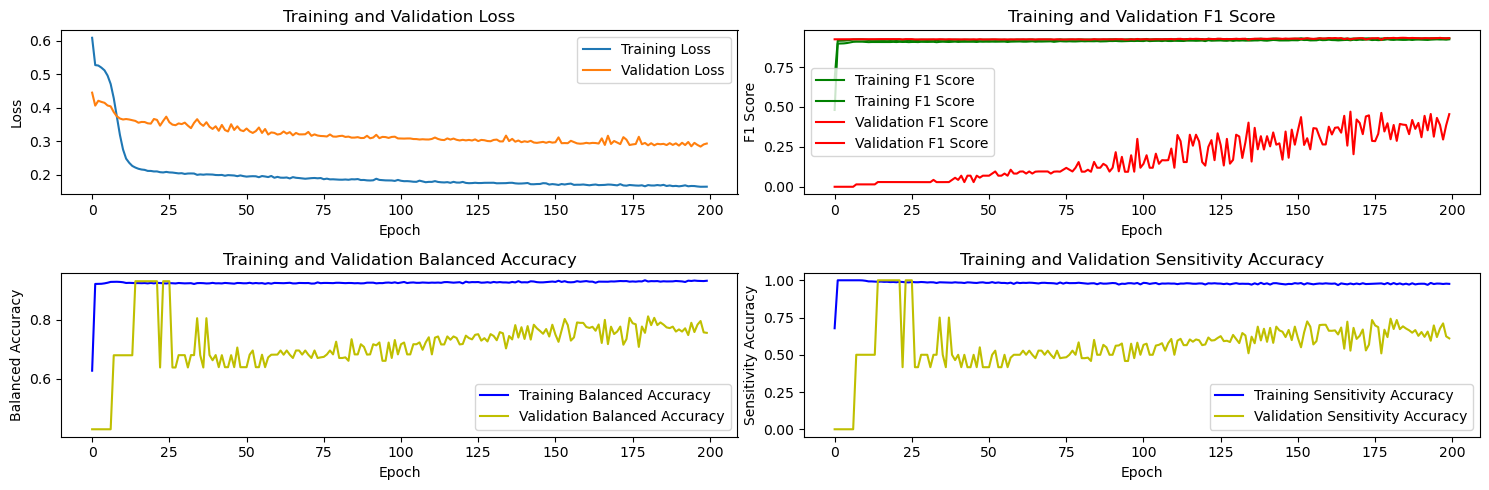

Train - Loss: 0.1646
Test  - Val Loss: 0.2936
Train - Mean F1 Score: 0.9169
Test - Mean Val F1 Score: 0.5547
Train - Final Sensitivity: 0.9760
Test - Final Val Sensitivity: 0.6101
Train - Final Balanced Accuracy: 0.9320
Test - Final Val Balanced Accuracy: 0.7558
861 78


In [27]:
test_eval_7 = NN_model.evaluate(val_images, val_labels, verbose=1)
print('Test f1:', test_eval_7[1])
check_results(history)
check_imbalance(NN_model, val_images)

### CNN4 with balanced augmentation(oversampling) and class weights

In [6]:
#REDE 4s - Data augmentation
def balance_augmentation(x, y):

    #separating x into matrixes with only one class of image - to enable to only augment the underrepresented class of images
    x_melanoma1 = np.empty([0,x.shape[1]])
    x_nervu0 = np.empty([0,x.shape[1]])
    for index,item in np.ndenumerate(y):
        if item:
            x_melanoma1 = np.vstack([x_melanoma1, x[index,:]])
        else:
            x_nervu0 = np.vstack([x_nervu0, x[index,:]])


    #Checking the imbalance in the data
    nr_y_melanoma=len([y for y in y_train if y])
    nr_y_nevu=len([y for y in y_train if not y])
    difference = nr_y_nevu - nr_y_melanoma

    #choosing to augment only the underrepresented class of data
    if difference >0:

        X_generator_train=x_melanoma1
        y_class_to_augment=1
    else:
        X_generator_train=x_nervu0
        y_class_to_augment=0
    y_generator_train=np.empty([X_generator_train.shape[0], 1])
    y_generator_train[:]=y_class_to_augment

    #creating and fitting image data generator
    data_generator = keras.preprocessing.image.ImageDataGenerator(
        rotation_range=360,
        width_shift_range=10,
        height_shift_range=10,
        brightness_range=[0.7,1.3],
        zoom_range=0.2,
        fill_mode='nearest',
        horizontal_flip=True,
        vertical_flip=True,
        )
    X_generator_train_reshape = np.reshape(X_generator_train,(X_generator_train.shape[0],28,28,3))
    data_generator.fit(X_generator_train_reshape)

    #creating arrays of new data/augmented data - only of underrepresented class
    x_augmented = np.empty([0,x.shape[1]])
    y_augmented = np.empty([0, 1])

    #generating data
    for batch_x, batch_y in data_generator.flow(X_generator_train_reshape, y_generator_train, batch_size=10, seed=1000):
        x_augmented = np.vstack([x_augmented,np.reshape(batch_x,(batch_x.shape[0],2352))])
        y_augmented = np.vstack([y_augmented, np.reshape(batch_y,(batch_y.shape[0],1))])
        if x_augmented.shape[0] >= difference:
            break

    balanced_x=np.vstack([x, x_augmented])
    balanced_y=np.vstack([np.reshape(y, (y.shape[0],1)), y_augmented])

    return balanced_x, balanced_y

X, y, X_t = load_data_2()
Xs, Xs_test = preprocess_data(X, X_t)
X_train, X_validation, y_train, y_validation = split_data(Xs, y)

train_balanced_x, train_balanced_y = balance_augmentation(X_train, y_train)
X_train_shuffle, y_train_shuffle = shuffle_data(train_balanced_x, train_balanced_y)
train_labels, train_images, val_images, val_labels = encode_data(y_train_shuffle, X_train_shuffle, y_validation, X_validation)

NN_model_b = Convolution_NN_4()
Compile_MLP_categorical_crossentropy(NN_model_b)
history = NN_model_b.fit(train_images, train_labels, validation_data=(val_images, val_labels), batch_size=512, epochs=200, shuffle=True, verbose=0)

def plot_images2(number_images, X_train):
    '''Plot a user-defined number of images from X_train. Works for any number of images.'''
    height, width, channels = X_train.shape[1], X_train.shape[2], X_train.shape[3]  # Define height, width, and channels based on the shape of X_train
    rows = int(np.ceil(number_images / 10))  # Calculate the number of rows based on the desired number of images
    plt.figure(figsize=(12, 6))
    for i in range(number_images):
        plt.subplot(rows, 10, i + 1)

        # Reshape the image if needed (e.g., if it's a flattened image)
        if X_train[i].shape != (height, width, channels):
            reshaped_image = np.reshape(X_train[i], (height, width, channels))
        else:
            reshaped_image = X_train[i]

        # Normalize the image data to [0, 1] range
        normalized_image_data = reshaped_image.astype(float) / 255.0

        if np.min(normalized_image_data) < 0 or np.max(normalized_image_data) > 1:
            raise ValueError("Image data is not in the [0, 1] range.")

        plt.imshow(normalized_image_data)
        plt.title(f"Image {i + 1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

#plot_images2(100, train_images)

Split X_train:  (5315, 2352)
Split y_train:  (5315,)


2023-10-27 02:15:31.480629: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-27 02:15:31.523262: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


30/30 [==============================] - 0s 4ms/step - loss: 0.2398 - f1_score: 0.7532 - sensitivity_custom: 0.6303 - balanced_accuracy_custom: 0.7784
Test f1: [0.94138974 0.5650224 ]


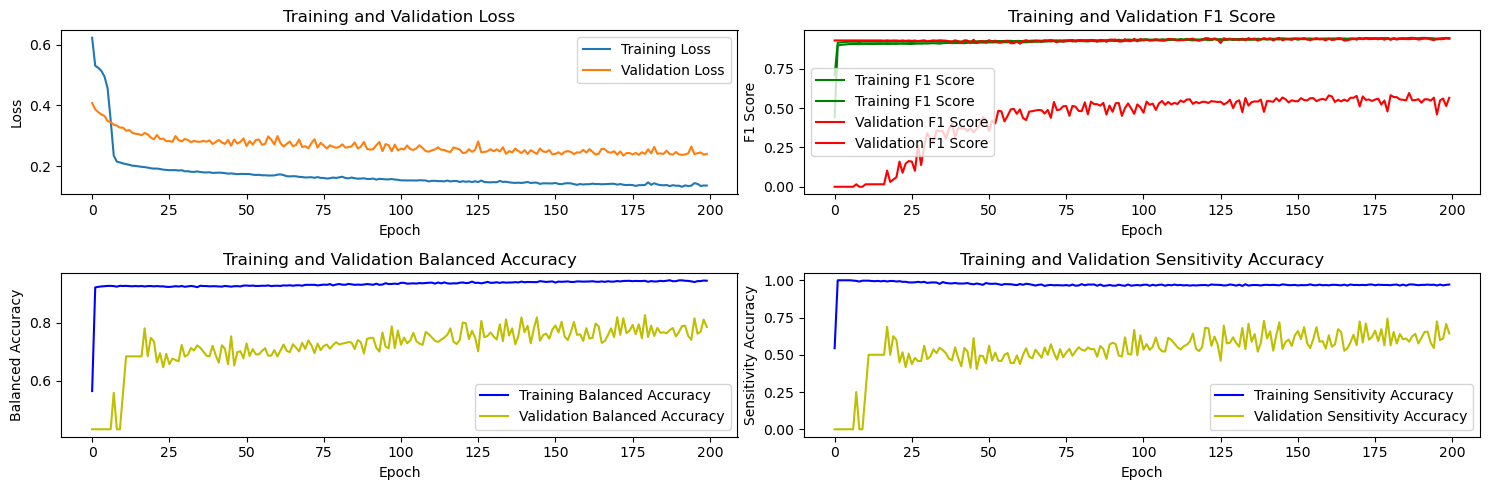

Train - Loss: 0.1357
Test  - Val Loss: 0.2398
Train - Mean F1 Score: 0.9277
Test - Mean Val F1 Score: 0.6846
Train - Final Sensitivity: 0.9714
Test - Final Val Sensitivity: 0.6432
Train - Final Balanced Accuracy: 0.9444
Test - Final Val Balanced Accuracy: 0.7855
840 99


In [7]:
test_eval_8 = NN_model_b.evaluate(val_images, val_labels, verbose=1)
print('Test f1:', test_eval_8[1])  
check_results(history)
check_imbalance(NN_model_b, val_images)

In [ ]:
test_images = np.reshape(Xs_test, (len(Xs_test[:,0]),28,28,3))
rounded_predictions = make_predictions(NN_model_b, test_images)
cont_0 = 0
for i in rounded_predictions: #Visualize imbalance in training data
    if i == 0:
        cont_0 += 1
print(cont_0, len(test_images[:,0])-cont_0) #See distribution between classes
print(rounded_predictions.shape)
np.save('ypredictions_lab3.npy', rounded_predictions)

1548 216
(1764,)


In [ ]:
def print_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Support Vector Machine with data augmentation


In [ ]:
X, y, X_t = load_data()
Xs, Xs_test = preprocess_data(X, X_t)
X_train, X_validation, y_train, y_validation = split_data(Xs, y)

train_balanced_x, train_balanced_y = balance_augmentation(X_train, y_train)
X_train_shuffle, y_train_shuffle = shuffle_data(train_balanced_x, train_balanced_y)

Split X_train:  (5315, 2352)
Split y_train:  (5315,)


In [ ]:
parameters = {'kernel': ['RBF', 'poly'],
              'gamma': [0.0001,0.001,0.1,1],
              'C': [0.1,1,5,10,50, 100]} #Define parameters for cross validation
svc = SVC()
svc_model = GridSearchCV(svc, parameters)
svc_model.fit(X_train_shuffle, np.ravel(y_train_shuffle))
y_predicted = svc.predict(X_validation)
b_acc = BACC(y_predicted, np.ravel(y_validation))

In [ ]:
print(svc_model.get_params)
print('Balanced accuracy', b_acc)
print(classification_report(y_validation, y_predicted, target_names=['0', '1']))
